In [13]:
from xbos import get_client
from xbos.services.pundat import DataClient, make_dataframe
from xbos.services.hod import HodClient
import datetime
import pandas as pd
import pytz
from datetime import timedelta
#from OccupancyThanos import *
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime
from scipy import spatial
import math
%matplotlib inline

In [14]:
def hamming_distance(a, b):
    return np.count_nonzero(a != b)


def eucl_distance(a, b):
    return pd.np.linalg.norm(a - b)


def mins_in_day(timestamp):
    return timestamp.hour * 60 + timestamp.minute

def find_similar_days(training_data, now, observation_length, k, method=hamming_distance):
    min_time = training_data.index[0] + timedelta(minutes=observation_length)
    # Find moments in our dataset that have the same hour/minute and is_weekend() == weekend.
    print min_time
    selector = ((training_data.index.minute == now.minute) &
                (training_data.index.hour == now.hour) &
                (training_data.index > min_time))

    """
    if now.weekday() < 5:
        selector = (
            (training_data.index.minute == now.minute) &
            (training_data.index.hour == now.hour) &
            (training_data.index > min_time) &
            (training_data.index.weekday < 5)
        )
    else:
        selector = (
            (training_data.index.minute == now.minute) &
            (training_data.index.hour == now.hour) &
            (training_data.index > min_time) &
            (training_data.index.weekday >= 5)
        )
    """

    similar_moments = training_data[selector][:-1]
    print len(similar_moments)
    obs_td = timedelta(minutes=observation_length)

    similar_moments['Similarity'] = [
        method(
            training_data[(training_data.index >= now - obs_td) &
                            (training_data.index <= now)].get_values(),
            training_data[(training_data.index >= i - obs_td) &
                            (training_data.index <= i)].get_values()
        ) for i in similar_moments.index
        ]

    indexes = (similar_moments.sort_values('Similarity', ascending=True)
                .head(k).index)
    return indexes
def predict(data, now, similar_moments, prediction_time, resample_time):

    prediction = np.zeros((int(math.ceil(prediction_time/resample_time)) + 1, len(data.columns)))
    for i in similar_moments:
        prediction += (float(1.) / float(len(similar_moments))) * data[(data.index >= i) & (data.index <= i + timedelta(minutes=prediction_time))]
    print data[data.index == now]['occ']
    prediction[0] = data[data.index == now]['occ']
    time_index = pd.date_range(now, now+timedelta(minutes=prediction_time),freq='15T')
    return pd.DataFrame(data=prediction, index=time_index)


In [15]:
c = get_client()
archiver = DataClient(c)
hod = HodClient("ciee/hod",c)

Saw [ucberkeley] archiver 4 seconds 844.382 ms ago
Saw [ciee/hod] HodDB 9 seconds 272.774 ms ago


In [16]:
occ_query = """SELECT ?occ ?uuid ?room WHERE {
?occ rdf:type/rdfs:subClassOf* brick:Occupancy_Sensor .
?occ bf:uuid ?uuid .
?occ bf:isLocatedIn ?room .
?room rdf:type brick:Room .
};
"""
occ_query = """SELECT ?x ?room ?uuid WHERE {
    ?x rdf:type/rdfs:subClassOf* brick:Occupancy_Sensor .
  	?x bf:isLocatedIn ?room .
    ?room bf:isPartOf bldg:SouthZone .
  	?x bf:uuid ?uuid .
};
"""
results = hod.do_query(occ_query)
uuids = [x['?uuid'] for x in results['Rows']]
rooms = [x['?room'] for x in results['Rows']]
mapping = dict(zip(uuids, rooms))
print results['Rows']

[{'?room': 'R211', '?uuid': 'cab606d0-6d14-3aff-a0c2-e862ae297f22', '?x': 'hamilton_005e_pir'}, {'?room': 'R208', '?uuid': 'bdbbbf7c-21c3-3b61-8469-8516a8c666dd', '?x': 'hamilton_002b_pir'}, {'?uuid': '497145c4-2087-3e89-9c8f-f54b87dfb016', '?room': 'R206', '?x': 'hamilton_0027_pir'}, {'?room': 'R208', '?uuid': '97ba99af-869b-3c43-94e3-93040c9bdd33', '?x': 'enlighted_Sensor02d455_occupancy'}, {'?room': 'R208', '?uuid': 'c27adbad-b1b5-342c-91eb-a6709d365871', '?x': 'enlighted_Sensor02d454_occupancy'}, {'?room': 'R208', '?uuid': 'aefa14ef-a13a-355b-9b87-51511db7f541', '?x': 'enlighted_Sensor02d444_occupancy'}, {'?room': 'R208', '?uuid': 'afed35be-ef70-341a-8bf4-565d815bfd90', '?x': 'enlighted_Sensor02d438_occupancy'}, {'?room': 'R210', '?uuid': '989ed503-9aa2-310e-abd3-464f6169e175', '?x': 'hamilton_002a_pir'}, {'?room': 'R208', '?uuid': '2f5c888d-c0c6-33b4-9c30-d609f1e16fea', '?x': 'enlighted_Sensor02d433_occupancy'}, {'?room': 'R208', '?uuid': '2b3f9905-3bb7-302a-9545-7bfe2eb63547', '?

In [17]:
start = '"2017-08-19 07:00:00 PST"'
end = '"2017-09-20 07:00:00 PST"'
#start = 'now'
#end = 'now -30d'

In [18]:
dfs = make_dataframe(archiver.window_uuids(uuids, end, start, '15min', timeout=120))
for uid, df in dfs.items():
    if 'mean' in df.columns:
        df = df[['mean']]
    df.columns = ['occ']
    dfs[uid] = df.resample('15min').mean()
    
df = dfs.values()[0]
if len(dfs) > 1:
    for newdf in dfs.values()[1:]:
        df['occ'] += newdf['occ']
df['occ'] = 1*(df['occ']>0)

df.index = df.index.tz_localize('US/Pacific')

2017-08-19 11:00:00-07:00
31
time
2017-09-01 00:00:00-07:00    1
Freq: 15T, Name: occ, dtype: int64


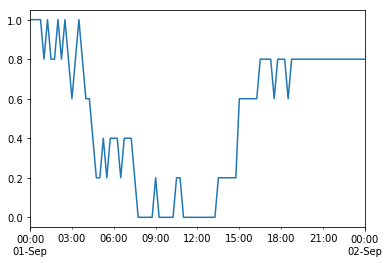

In [19]:
observation_length_addition = 4*60
k = 5
prediction_time = 24*60
resample_time = 15
now = datetime.datetime.now()
day = 1
hour = 0
minute = 0#resample_time * (now.minute / resample_time)
second = 0
now = datetime.datetime(year=now.year, month=now.month, day=day, hour=hour, minute=minute, second=second)
observation_length = mins_in_day(now) + observation_length_addition
similar_moments = find_similar_days(df, now, observation_length, k)
predictions = predict(df, now, similar_moments, prediction_time, resample_time)
d = np.squeeze(predictions)
d.plot()

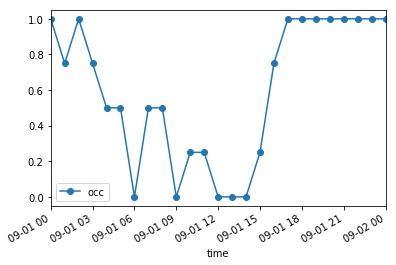

In [20]:
df[now:now+timedelta(minutes=prediction_time)].resample('1H').mean().plot(marker='o')

Things to do with prediction
- plot the envelope/curve
- plot per-room, per-zone
- general API for "occupancy data in range [t0, t1]", transparently populated with historic/predictive data
- support predictions of the past (for model evaluations)

What goes in the API?

Request:
- request window of occupancy data
- resolution of request (e.g. 15minutes, )
- some grouping mechanism, e.g. room, HVAC zone, building

Response:
- identify which ranges are historical, which are predicted
- RMS error of prediction
- actual timeseries of prediction

In [10]:
print now
print pd.date_range(now, now+timedelta(minutes=prediction_time),freq='15T')

2017-09-01 00:00:00
DatetimeIndex(['2017-09-01 00:00:00', '2017-09-01 00:15:00',
               '2017-09-01 00:30:00', '2017-09-01 00:45:00',
               '2017-09-01 01:00:00', '2017-09-01 01:15:00',
               '2017-09-01 01:30:00', '2017-09-01 01:45:00',
               '2017-09-01 02:00:00', '2017-09-01 02:15:00',
               '2017-09-01 02:30:00', '2017-09-01 02:45:00',
               '2017-09-01 03:00:00', '2017-09-01 03:15:00',
               '2017-09-01 03:30:00', '2017-09-01 03:45:00',
               '2017-09-01 04:00:00', '2017-09-01 04:15:00',
               '2017-09-01 04:30:00', '2017-09-01 04:45:00',
               '2017-09-01 05:00:00', '2017-09-01 05:15:00',
               '2017-09-01 05:30:00', '2017-09-01 05:45:00',
               '2017-09-01 06:00:00', '2017-09-01 06:15:00',
               '2017-09-01 06:30:00', '2017-09-01 06:45:00',
               '2017-09-01 07:00:00', '2017-09-01 07:15:00',
               '2017-09-01 07:30:00', '2017-09-01 07:45:00',
    

In [11]:
def clean_days(dfs):
    days = {}
    for uid, df in dfs.items():
        df = df[['mean']]
        df = df.tz_localize('UTC').tz_convert('US/Pacific')
        day_start = df.index[0].to_datetime()
        day_start = pytz.timezone('US/Pacific').localize(datetime.datetime(year=day_start.year, month=day_start.month, day=day_start.day))
        last_day = df.index[-1].to_datetime()
        days[uid] = []
        while day_start < last_day:
            day_end = day_start+datetime.timedelta(days=1)
            #print 'got day', pd.to_datetime(day_end)
            day = df[day_start:day_end]
            day.index = day.index.map(lambda x: datetime.datetime(year=2017, month=1, day=1, hour=x.hour, minute=x.minute, second=x.second))
            days[uid].append(day)
            day_start = day_end
    return days

In [12]:
days = clean_days(dfs)

KeyError: "['mean'] not in index"

In [ ]:
alldays = pd.concat(days,axis=1).fillna(0)
alldays.mean(axis=1).plot()

In [ ]:
for uid, subdays in days.items():
    df = pd.concat(subdays, axis=1).fillna(0)
    early = df[df['mean'] > 0].index.min()
    late = df[df['mean'] > 0].index.max()
    print mapping[uid],'has occupancy',early,late